In [3]:
#Imports:
import numpy as np
from qutip import *

In [4]:
#Ops:
def make_spin_ops(S):
    sx = jmat(S, 'x')
    sy = jmat(S, 'y')
    sz = jmat(S, 'z')
    return sx, sy, sz

sx, sy, sz = make_spin_ops(0.5)
print(sx, sy, sz)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.  0.5]
 [0.5 0. ]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]


In [5]:
def local_op(op, i, N, dim):
    ops = [qeye(dim) for _ in range(N)]  
    ops[i] = op                          
    return tensor(ops)           

def two_site_op(op1, i, op2, j, N, dim):
    ops = [qeye(dim) for _ in range(N)]  
    ops[i] = op1                         
    ops[j] = op2                         
    return tensor(ops)

In [13]:
#Onsite Disorder Hamiltonian:
def onsite_disorder(N, sz, h_d, distribution = "gaussian"):
    dim = sz.shape[0]
    H = 0
    if distribution == "gaussian":
        h_arr = np.random.normal(0, h_d, N)
    elif distribution == "uniform":
        h_arr = np.random.uniform(-h_d, h_d, N)
    else:
        raise ValueError("gaussian/uniform only")
    for i in range(N):
        H += h_arr[i] * local_op(sz, i, N, dim)
    return H
        

In [7]:
#Heisenberg Hamiltonian:
def heisenberg_ham(N, sx, sy, sz, Jx = 0, Jy = 0, Jz = 1, periodic = False):
    dim = sx.shape[0]
    H = 0
    for i in range((N-1)+ int(periodic)):
        H += Jx * two_site_op(sx, i, sx, (i+1)%N, N, dim)
        H += Jy * two_site_op(sy, i, sy, (i+1)%N, N, dim)
        H += Jz * two_site_op(sz, i, sz, (i+1)%N, N, dim)
    return H


In [8]:
#Ising Hamiltonian :
#Put h value if you want transverse field.
def ising_ham(N, sz, sx, J = 1, h = 0, periodic = False):
    dim = sz.shape[0]
    H = 0
    for i in range((N-1)+ int(periodic)):
        H += J * two_site_op(sz, i, sz, (i+1)%N, N, dim)
    for i in range(N):
        H += h * local_op(sx, i, N, dim)
    return H


In [2]:
#Antisymmetric Hamiltonian:
def dmi_ham(N, sx, sy, sz, Dx = 0, Dy = 0, Dz = 1, periodic = False):
    dim = sx.shape[0]
    H = 0
    for i in range((N-1)+ int(periodic)):
        H += Dx * (two_site_op(sy, i, sz, (i+1)%N, N, dim) - two_site_op(sz, i, sy, (i+1)%N, N, dim))
        H += Dy * (two_site_op(sz, i, sx, (i+1)%N, N, dim) - two_site_op(sx, i, sz, (i+1)%N, N, dim))
        H += Dz * (two_site_op(sx, i, sy, (i+1)%N, N, dim) - two_site_op(sy, i, sx, (i+1)%N, N, dim))
    return H


In [9]:
#Magnetization Evolution Setup:
def magnetization_ops(N, sx, sy, sz, dim):
    Sx_ops = [local_op(sx, i, N, dim) for i in range(N)]
    Sy_ops = [local_op(sy, i, N, dim) for i in range(N)]
    Sz_ops = [local_op(sz, i, N, dim) for i in range(N)]
    return Sx_ops, Sy_ops, Sz_ops

In [10]:
def initial_state_all_up(N):
    return tensor([basis(2,0) for _ in range(N)])  

def initial_state_plus_x(N):
    state_plus = (basis(2,0) + basis(2,1)).unit()
    return tensor([state_plus for _ in range(N)])


In [11]:
def evolve_and_measure(H, psi0, tlist, Sx_ops, Sy_ops, Sz_ops):
    result = sesolve(H, psi0, tlist, e_ops=Sx_ops+Sy_ops+Sz_ops)

    N = len(Sx_ops)
    Mx, My, Mz = [], [], []
    for t_index in range(len(tlist)):
        mx_t, my_t, mz_t = 0,0,0
        for i in range(N):
            mx_t += result.expect[i][t_index]
            my_t += result.expect[i+N][t_index]
            mz_t += result.expect[i+2*N][t_index]
        Mx.append(mx_t/N)
        My.append(my_t/N)
        Mz.append(mz_t/N)
    return np.array(Mx), np.array(My), np.array(Mz)


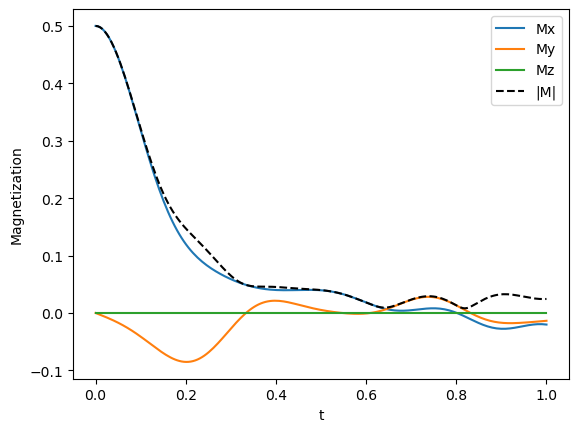

In [14]:
import numpy as np
import matplotlib.pyplot as plt

S = 0.5
sx, sy, sz = make_spin_ops(S)
dim = int(2*S+1)

N = 2

#H = ising_ham(N, sz, sx, J=1.0, h=0.5, periodic=False)

Sx_ops, Sy_ops, Sz_ops = magnetization_ops(N, sx, sy, sz, dim)

psi0 = initial_state_plus_x(N)

tlist = np.linspace(0, 1, 200)

Mx_total = np.zeros(len(tlist))
My_total = np.zeros(len(tlist))
Mz_total = np.zeros(len(tlist))

n_realizations = 100

for _ in range(n_realizations):
    H = onsite_disorder(N, sz, h_d=10, distribution ="gaussian")  
    Mx, My, Mz = evolve_and_measure(H, psi0, tlist, Sx_ops, Sy_ops, Sz_ops)
    Mx_total += Mx
    My_total += My
    Mz_total += Mz

Mx_avg = Mx_total / n_realizations
My_avg = My_total / n_realizations
Mz_avg = Mz_total / n_realizations
M_avg  = np.sqrt(Mx_avg**2 + My_avg**2 + Mz_avg**2) 

plt.plot(tlist, Mx_avg, label="Mx")
plt.plot(tlist, My_avg, label="My")
plt.plot(tlist, Mz_avg, label="Mz")
plt.plot(tlist, M_avg, label="|M|", linestyle='--', color='black')
plt.legend(); plt.xlabel("t"); plt.ylabel("Magnetization"); plt.show()
